# Time Series Forecast

# Functions

First, we define a set of functions that will be called later in the modelling and clustering stage. This will render our notebook much neater. Each functions is explanined in its defintion. 


In [ ]:
#!pip install statsmodels
#!pip install tbats
#!pip install pmdarima
#!pip install fastdtw

In [9]:
#basic libraries
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

#models
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.spatial.distance import euclidean
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

#metrics
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



In [41]:
#%% Transform data
def read_data ():
    """ 
    read train.csv as per normal.
    read calendar, drop redundant columns and format its 'date' column to be time stamps
    """ 
    df = pd.read_csv("/kaggle/input/ysc4224-final-project/train.csv")
    full_calendar = pd.read_csv("/kaggle/input/ysc4224-final-project/calendar.csv")
    calendar = full_calendar[:1919]
    calendar = calendar.drop(calendar.columns[np.r_[1,3:6]], axis = 1)
    format = '%Y-%m-%d'
    calendar['date'] = pd.to_datetime(calendar.date, format=format)
    return df, calendar , full_calendar

def transform_data (df,calendar):
    """ 
    df is the original training set. 
    calendar should be already trimmed and with index in datetime format.
    df will be transformed into vertical series with columns being product id and index timestamp
    """
    dft = df.T 
    dft.drop(index = ['item_id', 'subcat_id', 'category_id', 'store_id', 'region_id'],inplace = True)
    header = dft.iloc[0]
    dft = dft[1:]
    dft.columns = header 
    dft.reset_index( drop=True, inplace=True)
    calendar.reset_index(drop=True, inplace=True)
    dft = pd.concat([dft, calendar.date], axis = 1, ignore_index= False)
    dft.set_index('date', inplace = True)
    dft = dft.astype("float")
    return dft

#%%Aggregate by categories
def agg_and_date (df, calendar, cat, method):
    """ 
    aggregate by certain categories (eg. store, subcat)
    method can be "sum" or "mean"
    """
    if method == "sum":
        #aggregate sales by cat. take the sum
        subdf = df.groupby(by=cat).sum().transpose()
    elif method == "mean":
        #take the mean
        subdf = df.groupby(by=cat).mean().transpose()
    else:
        raise Exception()
    #concatenate calendar information with subdf
    subdf.reset_index( drop=True, inplace=True)
    calendar.reset_index( drop=True, inplace=True)
    subdf = pd.concat([subdf, calendar.date], axis = 1, ignore_index= False)
    subdf.set_index('date', inplace = True)
    return subdf


#%% Clustering

def natural_cluster_centroids(cluster_df):
    """
    if clustering by stores, df = store (aggregated)
    return: dictionary
    """
    centroids = {}
    for c in cluster_df.columns:
        centroids[c] = cluster_df[c]
    return centroids

def map_product_to_store (df):
    """     
    returns a dictionary where keys are product id and values are store id.
    helps to retrieve the product's store 
    """
    which_store =  pd.Series(df.store_id.values,index=df.id).to_dict()
    return which_store

def map_product_to_store_subcat (df):
    """     
    returns a dictionary where keys are product id and values are store id.
    helps to retrieve the product's store 
    """
    mapping =  pd.Series(df.store_subcat.values,index=df.id).to_dict()
    return mapping


def calculate_distance_last_week (cluster_df, dft, centroids, mapping):
    """ 
    cat: natural clusters (eg. store)
    mapping: dictionary that maps product to its natural cluster
    assume the distance each product to the average of the store is its sales divided by average sales of the previous week 
    """
    distances = {}
    for c in cluster_df.columns:
        distances[c] = {}

    for product in dft.columns:
        c = mapping[product]
        averages = centroids[c]
        cat_last_week_average = averages[(averages.index < "2016-04-30") & (averages.index >= "2016-04-21")].mean()
        product_sales = dft[product]
        product_last_week_average = product_sales[(product_sales.index < "2016-04-30") & (product_sales.index >= "2016-04-21")].mean()
        distances[c][product] = product_last_week_average/cat_last_week_average
    return distances

def calculate_distance_weighted (cluster_df, dft, centroids, mapping):
    """ 
    the last week's average get 0.8 weight and second last week's get 0.2 weight
    """
    distances = {}
    for c in cluster_df.columns:
        distances[c] = {}
    for product in dft.columns:
        c = mapping[product]
        averages = centroids[c]
        cat_last_week_average = averages[(averages.index < "2016-04-30") & (averages.index >= "2016-04-24")].mean()
        cat_last_last_average = averages[(averages.index < "2016-04-23") & (averages.index >= "2016-04-17")].mean()
        product_sales = dft[product]
        product_last_week_average = product_sales[(product_sales.index < "2016-04-30") & (product_sales.index >= "2016-04-24")].mean()
        product_last_last_average = product_sales[(product_sales.index < "2016-04-23") & (product_sales.index >= "2016-04-17")].mean()
        last_week = product_last_week_average/cat_last_week_average
        last_last = product_last_last_average/cat_last_last_average
        distances[c][product] = last_week * 0.8 + last_last *0.2
    return distances


#%% Build model

def build_ets_model (data):
    """ additive ETS model """
    model = ETSModel(
            data,
            error="add",
            trend="add",
            seasonal="add",
            damped_trend=True,
            seasonal_periods=7)
    return model

def build_sARIMA_model (data):
    #build autoarima model
    model = pm.auto_arima(data, 
        start_p=0, start_q=0, start_d=0, 
        max_p=2, max_q=2,     
        max_d=2, d=None,      
        seasonal=True,       
        m=7,                 
        start_P=0, start_Q=1, 
        max_P=0, max_Q=1,     
        D=1,                  
        test='adf',          
        information_criterion='aic', 
        trace=True,         
        error_action='ignore',   
        suppress_warnings=True, 
        stepwise=True
        )
    return model

def build_sARIMA_model_params (data,name,param_dict):
    #arima model with known parameters
    params = param_dict[name]
    model = SARIMAX(data, order=params['order'], seasonal_order=params['seasonal_order'])
    return model

#%% prediction

def model_predict_ets (model, start = "2016-05-01", end = "2016-05-21"):
    """ 
    make future prediction for one series of data 
    """
    fit = model.fit()
    pred = fit.get_prediction(start=start, end=end)
    predictions = pred.summary_frame(alpha=0.05)
    return predictions["mean"]

def predict_centroids_ets (cluster_df,centroids, model_func):
    """ 
    make predictions for centroids
    centroids are in series format 

    if centroids are store averages, df = store (aggregated)
    """
    centroid_predictions = {} 
    for i in range(len(centroids)):
        name = cluster_df.columns[i]
        centroid = centroids[name]
        model = model_func (centroid)
        centroid_predictions[name] = model_predict_ets(model)

    return centroid_predictions


def model_predict_arima (model, cluster_df, start = "2016-05-01", end = "2016-05-21"):
    """ 
    make future prediction for one series of data 
    """
    fit = model.fit(cluster_df)
    pred = fit.predict(21)
    print("predicted ",str(len(pred)), " days")
    return pred

def predict_centroids_arima (cluster_df,centroids, model_func):
    """ 
    make predictions for centroids
    centroids are in series format 

    if centroids are store averages, df = store (aggregated)
    """
    centroid_predictions = {} 
    for i in range(len(centroids)):
        name = cluster_df.columns[i]
        centroid = centroids[name]
        model = model_func (centroid)
        centroid_predictions[name] = model_predict_arima(model, centroid)
        print("finished prediction for ",name,"\n")
    return centroid_predictions

def model_predict_arima_params (model, start = "2016-05-01", end = "2016-05-21"):
    """ 
    make future prediction for one series of data 
    """
    fit = model.fit()
    pred = fit.get_prediction(start=start, end=end)
    predictions = pred.summary_frame(alpha=0.05)
    print("predicted ",str(len(predictions)), " days")
    return predictions["mean"]

def predict_centroids_arima_params (cluster_df,centroids, model_func, param_dict):
    centroid_predictions = {} 
    for i in range(len(centroids)):
        name = cluster_df.columns[i]
        centroid = centroids[name]
        model = model_func (centroid,name,param_dict)
        centroid_predictions[name] = model_predict_arima_params(model)
        print("finished prediction for ",name,"\n")
    return centroid_predictions

def predict_for_all (dft, centroid_predictions, distances, which_store):
    """
    with predictions of the centroid, calculates the predictions by multiplying the 
    centroid with a distance index
    """
    predictions = {}
    for product in dft.columns:
        store = which_store[product]
        centroid_prediction = centroid_predictions[store]
        product_prediction = centroid_prediction * (distances[store][product])
        predictions[product] = product_prediction
    return predictions

#%% Evaluation 

def evaluate_model_ets (df, model_func):
    """ 
    Split the data into 12 parts, use the sliding window method to 
    cross validate. Test set size is always 21. 
    Compute the rmse for the predictions of each product/cluster (21 predictions).
    The final score is the average of the list of rmse
    """
    t1 = time.time()
    rmse = []
    mae = []
    rmse_averages = []
    mae_averages = []
    tscv = TimeSeriesSplit(n_splits=12, test_size=21)
    for c in df.columns:
        ts_data_load = df[c]
        for train_index, test_index in tscv.split(ts_data_load):
            train, test = ts_data_load.iloc[train_index], ts_data_load.iloc[test_index] 
            model = model_func(train)
            fit = model.fit()
            pred = fit.get_prediction(test.index.values[0], test.index.values[-1])
            predictions = pred.summary_frame(alpha=0.05)
            predicted_values = predictions["mean"]
            true_values = test.values
            rmse.append(sqrt(mean_squared_error(true_values, predicted_values)))
            mae.append(mean_absolute_error(true_values, predicted_values))
    rmse_averages.append(np.mean(rmse))
    mae_averages.append(np.mean(mae))
    t2 = time.time()
    result = (np.mean(rmse_averages) , np.mean(mae_averages))
    print("centroid prediction rmse: ", str(round(result[0],2)))
    print("centroid prediction mae: ",str(round(result[1],2)))
    print("time taken: ", str(round(t2-t1,2)))

    return result

def evaluate_model_arima (df, model_func, param_dict):
    """ 
    Split the data into 12 parts, use the sliding window method to 
    cross validate. Test set size is always 21. 
    Compute the rmse for the predictions of each product/cluster (21 predictions).
    The final score is the average of the list of rmse
    """
    t1 = time.time()
    rmse = []
    mae = []
    rmse_averages = []
    mae_averages = []
    tscv = TimeSeriesSplit(n_splits= 3, test_size=21)
    for c in df.columns:
        ts_data_load = df[c]
        for train_index, test_index in tscv.split(ts_data_load):
            train, test = ts_data_load.iloc[train_index], ts_data_load.iloc[test_index] 
            model = model_func(train,c,SARIMA_params)
            fit = model.fit()
            pred = fit.get_prediction(test.index.values[0], test.index.values[-1])
            predictions = pred.summary_frame(alpha=0.05)
            predicted_values = predictions["mean"]
            true_values = test.values
            rmse.append(sqrt(mean_squared_error(true_values, predicted_values)))
            mae.append(mean_absolute_error(true_values, predicted_values))
    rmse_averages.append(np.mean(rmse))
    mae_averages.append(np.mean(mae))
    t2 = time.time()
    result = (np.mean(rmse_averages) , np.mean(mae_averages))
    print("centroid prediction rmse: ", str(round(result[0],2)))
    print("centroid prediction mae: ",str(round(result[1],2)))
    print("time taken: ", str(round(t2-t1,2)))

    return result

def evaluate_simple_ets (dft,cluster_df, centroids, distances, mapping, model_func):
    """ 
    compare the prediction of 2016 april to actual data 
    return rmse,mae
    """
    t1 = time.time()
    centroid_predictions = {} 
    for name in cluster_df.columns:
        centroid = centroids[name]
        model = model_func (centroid)
        centroid_predictions[name] = model_predict_ets(model, start = '2016-04-01', end = '2016-04-30')
    product_predictions  = predict_for_all (dft, centroid_predictions, distances, mapping)
    true_df = dft.loc['2016-04-01':'2016-04-30']
    rmse = []
    mae = []
    for product in true_df.columns:
        predicted_values = product_predictions[product].values
        true_values = true_df[product].values
        rmse.append(sqrt(mean_squared_error(true_values, predicted_values)))
        mae.append(mean_squared_error(true_values, predicted_values))
    result = (np.mean(rmse),np.mean(mae))
    t2 = time.time()
    print("product prediction rmse: ", str(round(result[0],2)))
    print("product prediction mae: ", str(round(result[1],2)))
    print("time taken: ", str(round(t2-t1,2)))
    return result

def evaluate_simple_arima (dft,cluster_df, centroids, distances, mapping, model_func,param_dict):
    """ 
    compare the prediction of 2016 april to actual data 
    return rmse,mae
    """
    t1 = time.time()
    centroid_predictions = {} 
    for name in cluster_df.columns:
        centroid = centroids[name]
        model = model_func (centroid,name, param_dict)
        centroid_predictions[name] = model_predict_arima_params(model, start = '2016-04-01', end = '2016-04-30')
    product_predictions  = predict_for_all (dft, centroid_predictions, distances, mapping)
    true_df = dft.loc['2016-04-01':'2016-04-30']
    rmse = []
    mae = []
    for product in true_df.columns:
        predicted_values = product_predictions[product].values
        true_values = true_df[product].values
        rmse.append(sqrt(mean_squared_error(true_values, predicted_values)))
        mae.append(mean_squared_error(true_values, predicted_values))
    result = (np.mean(rmse),np.mean(mae))
    t2 = time.time()
    print("product prediction rmse: ", str(round(result[0],2)))
    print("product prediction mae: ", str(round(result[1],2)))
    print("time taken: ", str(round(t2-t1,2)))
    return result

def format_result (predictions,full_calendar,name):
    """ 
    transform predictions(dictionary) into dataframe ready for submission
    """
    pred_df = pd.DataFrame(predictions)
    pred_cal = full_calendar.loc[(full_calendar['date'] >= '2016-05-01') & (full_calendar['date'] <= '2016-05-21'), ]
    pred_df.index = pred_cal.d
    result = pred_df.T
    #format prediction. turn time stamps into d_ 
    result = result.rename_axis('id').rename_axis(None, axis="columns")
    result.to_csv(name)
    return result



In [11]:
df, calendar , full_calendar = read_data()
#transpose df and make columns the product id and index the timestamp
dft = transform_data (df,calendar)

# Natural Clusters

Note that we attempted clustering the series via dtw distance. Directly clustering every time series was computationally unfeaisble (in the order of days, with the computational power available). Thus, we had to sample random samples of series from the training dataset, understand the optimal number of centroids form this subsample (was established to be 10), then assign each series to a centroid computing the dtw distance between each series and each centroid. This method was computationally feasible (~ 3 hours total computational time), but yielded poor results. Hence, we decided to use stores as "natural clusters", predicting the demand by store, and deaggregating the predicted demand knowing that each product demand is always a proportion of the total sales of the respective store. This approach, while incredibly computationally less expensive, yielded very decent results, once again reminding us that simpler can be quite performing and optimise the use of our resources too.

## Clustering by Subcategory per store
 The first approach is more meticolous, dividing the dataset into 70 clusters according to stores and subcategories, then predicting and de-aggregating the prediction accoridngly per product. The results obtained are very decent, especially the MAE. However, the RMSE is higgher than the one obtained with a more approximative clustering by store. 
### Model ETS (AAA)

In [13]:
#group the products by their stores 
# we get 70 clusters
cluster_df = agg_and_date (df, calendar, ["store_id","subcat_id"], "mean")
#format cluster names to string
cols = pd.Series(cluster_df.columns)
cluster_df.columns = cols.apply(lambda x: "_".join(x))
#concatenate store and subcat to match cluster names
df['store_subcat'] =  ""
for index,row in df.iterrows():
    store = str(row['store_id'])
    subcat = str(row['subcat_id'])
    name = str(store+"_"+subcat)
    df.loc[index, 'store_subcat'] = name
#get the centroid of store-subcat aka. time series of its average sales per product
centroids = natural_cluster_centroids(cluster_df)
#predict the average sales of store-subcat
centroid_predictions = predict_centroids_ets (cluster_df,centroids,build_ets_model)
#calculate the distances from product to cluster average
mapping = map_product_to_store_subcat (df)
distances = calculate_distance_weighted (cluster_df, dft, centroids, mapping)
#calculate the predictions for all products within the cluster 
predictions = predict_for_all (dft, centroid_predictions, distances, mapping)

In [17]:
# simple test: evaluate product predictions on 2016 April data
evaluate_simple_ets (dft,cluster_df,centroids, distances, mapping, build_ets_model)
# product prediction rmse:  1.29
# product prediction mae:  4.09
# time taken:  38.63
# kaggle score: 2.25700

product prediction rmse:  1.29
product prediction mae:  4.09
time taken:  38.63


In [ ]:
#format the result and export
# res = format_result (predictions,full_calendar,"store_subcat_last_week.csv")

## Clustering by store
Under the assumption that the sales of each product is always a proportion of the total sales of the store, we treat each store as a natural cluster.  

The cluster cetroid is the average sales for the store. We perform prediction on these centroids, and calculate predictions to individual products based on their distance to the centroid.

Products' distance to the centroid is measured by their average sales in the last week relative to the average sales of the cluster, the store where they are selling. 

### Model: ETS (AAA)
Note that the ETS (AAA) model perfomrs very similarly to the above ETS9AAA) model which used 70 clusters. Once again, apporxmation seems to save computing time at no nost in accuracy (this model performed better on the kaggle test set than the above one).

In [18]:
#group the products by their stores
stores = agg_and_date (df, calendar, "store_id", "mean")
#get the centroid of store aka. time series of its average sales per product
store_centroids = natural_cluster_centroids(stores)
#predict the average sales of stores
store_average_predictions = predict_centroids_ets (stores,store_centroids,build_ets_model)
#calculate the distances from product to store average
which_store = map_product_to_store (df)
distances = calculate_distance_weighted(stores, dft, store_centroids, which_store)
#calculate the predictions for all products within the cluster 
predictions = predict_for_all (dft, store_average_predictions, distances, which_store)

In [22]:
# sliding window cross validation: measure the accuracy of prediction on average sales per store
rmse_centroids = evaluate_model_ets (stores, build_ets_model)
# simple test: evaluate product predictions on 2016 April data
rmse = evaluate_simple_ets (dft,stores, store_centroids, distances, which_store, build_ets_model)
# centroid prediction rmse:  0.19
# centroid prediction mae:  0.15
# time taken:  31.6
# product prediction rmse:  1.3
# product prediction mae:  4.16
# time taken:  20.45
# kaggle score: 2.23949

centroid prediction rmse:  0.19
centroid prediction mae:  0.15
time taken:  31.99
product prediction rmse:  1.3
product prediction mae:  4.16
time taken:  20.64


In [ ]:
#format the result and export
# res = format_result (predictions,full_calendar,"store_ets_weeks_weighted.csv")


### ETS(AAA) with post-2015 data
In EDA we observed that store trends stablise after mid 2015. Perhaps using post-mid 2015 data will give us better predictions

In [23]:
#group the products by their stores 
cluster_df = agg_and_date (df, calendar, "store_id", "mean")
#trumcate df
cluster_df = cluster_df.loc["2015-01-01":]

In [24]:
#get the centroid of store aka. time series of its average sales
centroids = natural_cluster_centroids(cluster_df)
#predict the average sales of store
centroid_predictions = predict_centroids_ets (cluster_df,centroids,build_ets_model)
#calculate the distances from product to cluster average
mapping = map_product_to_store (df)
distances = calculate_distance_last_week (cluster_df, dft, centroids, mapping)
#calculate the predictions for all products within the cluster 
predictions = predict_for_all (dft, centroid_predictions, distances, mapping)

In [25]:
# sliding window cross validation: measure the accuracy of prediction on average sales per store
metrics_centroids = evaluate_model_ets (cluster_df, build_ets_model)
# simple test: evaluate product predictions on 2016 April data
metrics = evaluate_simple_ets (dft,cluster_df, centroids, distances, mapping, build_ets_model)

# centroid prediction rmse:  0.18
# centroid prediction mae:  0.14
# time taken:  14.07
# product prediction rmse:  1.3
# product prediction mae:  4.16
# time taken:  19.22
# kaggle score: 2.23849

centroid prediction rmse:  0.18
centroid prediction mae:  0.14
time taken:  14.07
product prediction rmse:  1.3
product prediction mae:  4.16
time taken:  19.22


In [ ]:
#format the result and export
# res = format_result (predictions,full_calendar,"store_last_week_ets_2015.csv")

### Automated Seasonal ARIMA
Below are the selected ARIMA parameters for prediction cluster centroids. Due to the run time, we comment out the code and report the selcted Sarima parameters by the stepwise algorithm. 

In [ ]:
# #group the products by their stores 
# cluster_df = agg_and_date (df, calendar, "store_id", "mean")
# #get the centroid of store aka. time series of its average sales
# centroids = natural_cluster_centroids(cluster_df)
# #predict the average sales of store
# centroid_predictions = predict_centroids_arima (cluster_df,centroids,build_sARIMA_model)
# #calculate the distances from product to cluster average
# mapping = map_product_to_store (df)
# distances = calculate_distance_last_week (cluster_df, dft, centroids, mapping)
# #calculate the predictions for all products within the cluster 
# predictions = predict_for_all (dft, centroid_predictions, distances, mapping)

In [27]:
SARIMA_params = {
"Central_1" : { "order": (0,0,4), "seasonal_order": (0,1,1,7)},
"Central_2": { "order": (1,0,4), "seasonal_order": (0,1,1,7)},
"Central_3": { "order": (0,0,4), "seasonal_order": (0,1,1,7)},
"East_1": { "order": (1,0,4), "seasonal_order": (0,1,1,7)},
"East_2": { "order": (1,0,4), "seasonal_order": (0,1,1,7)},
"East_3": { "order": (0,0,4), "seasonal_order": (0,1,1,7)},
"East_4": { "order": (0,0,4), "seasonal_order": (0,1,1,7)},
"West_1": { "order": (1,0,4), "seasonal_order": (0,1,1,7)},
"West_2": { "order": (0,0,4), "seasonal_order": (0,1,1,7)},
"West_3": { "order": (2,0,1), "seasonal_order": (0,1,1,7)}
}

Here we we demonstrate how we built a seasonal arima model for each cluster centroid

In [28]:
centroids = natural_cluster_centroids(cluster_df)
centroid_predictions = predict_centroids_arima_params (cluster_df,centroids, build_sARIMA_model_params, SARIMA_params)
mapping = map_product_to_store (df)
distances = calculate_distance_weighted (cluster_df, dft, centroids, mapping)
#calculate the predictions for all products within the cluster 
predictions = predict_for_all (dft, centroid_predictions, distances, mapping)

predicted  21  days
finished prediction for  Central_1 

predicted  21  days
finished prediction for  Central_2 

predicted  21  days
finished prediction for  Central_3 

predicted  21  days
finished prediction for  East_1 

predicted  21  days
finished prediction for  East_2 

predicted  21  days
finished prediction for  East_3 

predicted  21  days
finished prediction for  East_4 

predicted  21  days
finished prediction for  West_1 

predicted  21  days
finished prediction for  West_2 

predicted  21  days
finished prediction for  West_3 



In [42]:
# sliding window cross validation: measure the accuracy of prediction on average sales per store
# rmse_centroids = evaluate_model_arima (cluster_df, build_sARIMA_model_params,SARIMA_params)
# simple test: evaluate product predictions on 2016 April data
rmse = evaluate_simple_arima (dft,cluster_df, store_centroids, distances, which_store, build_sARIMA_model_params,SARIMA_params)
# centroid prediction rmse:  0.17
# centroid prediction mae:  0.12
# time taken:  269.4
# product prediction rmse:  1.3
# product prediction mae:  4.14
# time taken:  79.97
# kaggle score: 2.23917

predicted  30  days
predicted  30  days
predicted  30  days
predicted  30  days
predicted  30  days
predicted  30  days
predicted  30  days
predicted  30  days
predicted  30  days
predicted  30  days
product prediction rmse:  1.3
product prediction mae:  4.14
time taken:  79.97


# Visualize Results

<Figure size 1440x720 with 0 Axes>

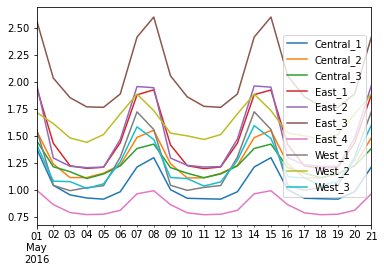

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
predf = pd.DataFrame(centroid_predictions)
predf.plot()
plt.legend(loc = "right")

# Modelling conclusions

We conclude that ETS (AAA) that utilises the whole trainig data and 10 stores as cluster is our best model since it yields about the same RMSE and a slightly lower RMSE on our test set, with significantly less computational time (~ 1 minute) compared to the SARIMA model (about 40 minutes needed with the indicated restrictions) and other ETS(AAA) models ran. Also, our ETS (AAA) model obtains a slightly lower RMSE score on the keggle test set. 

Going further,  and with more computational power available, we would perform ETS on every series and try clustering with series statistics like DTW distance on the whole training data. We could also explore ways to include the ETS(AAA) model with ARIMA, with models like TBATS. Again, more computational power would be needed to fit such models in reasonable time. 

## Key insights from Analysis

We understand that the trade off between computational expensiveness and accuracy suggests for more simple models to be used for this forecasting exercise. More exactly, an ETS (AAA) model based on 10 stores as natural clusters outperforms or performs only slightly worse than more complex models like ARIMA and SARIMA.

Our analysis highlted that anomalies in the series are sub_category and region specific. For future long term forecasts, we shall garner more contextual data to better understand those anomalies and incoporate them in our predictions. Also, more data and/or information is needed to understand why most stores's demand has plateud after 2014. Whether this issue arose due to growing physical or online competion, or other general demographic trends, understanding the cause of this change in trend is pivotal to formulate market seizing strategies that can invert this slumping trend.

Similarly, we suggest the company to undergo market basket analysis to better understand the relationship between products in different categorise (substitutes, complementary items) and to possibly incorporate these in the forecasting model.

Last, more context should be given to the final forecast, especially to understand the different volumes of demand that shops face. In our forecast, shop 'East_4' has the smallest predicted demand, along with the less significant fluctuations. More information is needed on the demographics of the locality, closeness of competitions and size of inventory to establish a cause for these differences between trends. understanding them might result in improvement strategies that aim at reproducing the conditions of higher-selling stores like 'East_3', where possible.